In [1]:
from sklearn import preprocessing
import sklearn
import matplotlib.ticker as ticker
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import seaborn as sns
%matplotlib inline
%pylab inline

from tqdm import tqdm_notebook
from math import sqrt

Populating the interactive namespace from numpy and matplotlib


In [2]:
Type = 'XGBoost_reg'
Datasets_amount = 3
Features = 'All'
Grid_search = True
Save_results = False
Random_seed = 1
Metodology = 'mibel'
Save_graphs = False
Print_graphs = True
Print_metrics = True

In [3]:
train = []
test = []

for i in range(3):
    train.append(pd.read_csv('Train_CE_{}.csv'.format(i+1)).drop(columns = ['Unnamed: 0']))
    test.append(pd.read_csv('Test_CE_{}.csv'.format(i+1)).drop(columns = ['Unnamed: 0']))

#     test[i]['test_label'] = np.ones(test[i]['time'].shape) 
#     train[i]['test_label'] = np.zeros(train[i]['time'].shape) 
#     data = pd.concat([train[i], test[i]])
#     df = data.drop(columns = ['APGEN1'])
#     df = data.drop(columns = ['APGEN2'])
#     df = pd.concat([df[df.columns[:-2]],\
#            pd.get_dummies(data['APGEN1'], prefix = 'apgen1', dummy_na = True),\
#            pd.get_dummies(data['APGEN2'], prefix = 'apgen2', dummy_na = True),\
#            df[df.columns[-2:]]], axis = 1)
#     train[i] = df.loc[df['test_label'] == 0].drop(columns = ['test_label'])
#     test[i] = df.loc[df['test_label'] == 1].drop(columns = ['test_label'])

In [4]:
MRT_cols = []
clinical_cols = []
for col in train[0].columns[3:-1]:
    if col.find('f_') == -1:
        clinical_cols.append(col)
    else:
        MRT_cols.append(col)

default_colls = train[0].columns[:3]
target_coll = train[0].columns[-1]

In [7]:
def only_clinical_df(df):
    all_df = df.loc[:,default_colls]
    Target = df[target_coll]
    return pd.concat([all_df, df.loc[:,clinical_cols], Target], axis = 1).sort_values(by = ['RID', 'time'])

In [8]:
def only_MRT_df(df):
    all_df = df.loc[:,default_colls]
    Target = df[target_coll]
    return pd.concat([all_df, df.loc[:,MRT_cols], Target], axis = 1).sort_values(by = ['RID', 'time'])

In [9]:
def all_feat_df(df):
    return df

In [10]:
def read_array(file_name):
    f = open(file_name, 'r')
    x = f.readlines()
    for i in range(len(x)):
        x[i] = float(x[i].split()[0])
    f.close()
    return np.array(x)

In [11]:
Train = []
Test = []
for i in range(3):
    if Features == 'All':
        Train.append(all_feat_df(train[i]))
        Test.append(all_feat_df(test[i]))
    elif Features == 'Clinical':
        Train.append(only_clinical_df(train[i]))
        Test.append(only_clinical_df(test[i]))
    else:
        Train.append(only_MRT_df(train[i]))
        Test.append(only_MRT_df(test[i]))

In [12]:
def debute_time(df):
    if len(numpy.where(df['DXCURREN'].values == 1)[0]) == 0:
        df['debute time'] = [-1]*len(df)
    else:
        df['debute time'] = [numpy.where(df['DXCURREN'].values == 1)[0][0]*6]*len(df)
    return df

In [13]:
for dataset_num in range(Datasets_amount):
    Train[dataset_num]['debute time'] = 0
    Train[dataset_num] = Train[dataset_num].groupby('RID').apply(debute_time)
    Train[dataset_num]['relative_debute time'] = Train[dataset_num]['debute time'] - Train[dataset_num]['time']
    Train[dataset_num].drop(Train[dataset_num].loc[Train[dataset_num]['relative_debute time'] < 0].index, inplace = True)
    Train[dataset_num].reset_index(drop = True, inplace = True)
    
    Test[dataset_num]['debute time'] = 0
    Test[dataset_num] = Test[dataset_num].groupby('RID').apply(debute_time)
    Test[dataset_num]['relative_debute time'] = Test[dataset_num]['debute time'] - Test[dataset_num]['time']
    Test[dataset_num].drop(Test[dataset_num].loc[Test[dataset_num]['relative_debute time'] < 0].index, inplace = True)
    Test[dataset_num].reset_index(drop = True, inplace = True)

In [14]:
def get_x_y(df):
    x = df.drop(columns = Test[0].columns[np.where(Test[0].columns == 'relative_debute time')[0][0]:])
    x = x.drop(columns = ['DXCURREN', 'debute time'])
    y = list(df['relative_debute time'].values)
    return x, y

In [15]:
for dataset_num in range(Datasets_amount):
    Test[dataset_num]  = Test[dataset_num].loc[Test[dataset_num]['debute time'] != 0]
    Train[dataset_num] = Train[dataset_num].loc[Train[dataset_num]['debute time'] != 0]

In [16]:
x_train = []
y_train = []

x_test = []
y_test = []

for dataset_num in range(3):
    x, y = get_x_y(Train[dataset_num])
    x_train.append(x)
    y_train.append(y)
    
    x, y = get_x_y(Test[dataset_num])
    x_test.append(x)
    y_test.append(y)

In [17]:
x_test_m = []
x_train_m = []
for dataset_num in range(3):
    x_test_m.append(x_test[dataset_num].drop(columns=['RID']).as_matrix())
    x_train_m.append(x_train[dataset_num].drop(columns=['RID']).as_matrix())

/nmnt/media/home/l0ki4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/nmnt/media/home/l0ki4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


# XGBoost

In [18]:
def get_weight_ratio(y_train):
    return len(y_train_arr[y_train_arr == 0])/len(y_train_arr[y_train_arr == 1])

In [19]:
from sklearn.model_selection import GroupKFold

In [20]:
def grid_search_model(dataset_num):
    X = x_train_m[dataset_num]
    y = np.array(y_train[dataset_num])
    groups = x_train[dataset_num].RID.values.astype(int)
    group_kfold = GroupKFold(n_splits=5)
    group_kfold.get_n_splits(X, y, groups)

    scores = []
    min_score = np.inf
    best_lr = 0
    best_depth = 0
    for lr in tqdm_notebook([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1], ascii = True, desc = 'learning rate'):
        for depth in tqdm_notebook([1,2,4,6,8,10,12], ascii = True, desc = 'depth'):
            for train_index, test_index in group_kfold.split(X, y, groups):
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = y[train_index], y[test_index]

                tree = XGBRegressor(n_estimators= 2000, learning_rate = lr, max_depth = depth, silent=True,\
                                     objective = 'reg:linear',random_state=Random_seed, n_jobs = 12)

                tree.fit(X_train, Y_train,\
                         eval_set= [(X_test, Y_test)],\
                         eval_metric = 'rmse', early_stopping_rounds = 50, verbose = False)

                y_pred = tree.predict(x_test_m[dataset_num])
                scores.append(sqrt(mse(y_test[dataset_num], y_pred)))

                print(mean(scores), end = '')
                print('\r', end='')
                
            if mean(scores) < min_score:
                min_score = mean(scores)
                best_lr = lr
                best_depth = depth
            scores = []
            if best_lr == lr and best_depth == depth:
                print('Лучшее на данный момент: LR = {}, Depth = {}, Mean RMSE = {}'.format(best_lr,\
                                                                          best_depth, min_score),\
                      end = '')
                print('\r', end='')
                print()
            
    tree = XGBRegressor(n_estimators= 2000, learning_rate = best_lr, max_depth = best_depth, silent=True,\
                                     objective = 'reg:linear',random_state=Random_seed, n_jobs = 12)

    tree.fit(X_train, Y_train,\
             eval_set= [(X_test, Y_test)],\
             eval_metric = 'rmse', early_stopping_rounds = 50, verbose = False)

    print('lr', best_lr)
    print('depth', best_depth)
    return tree

In [21]:
def train_model(dataset_num, lr, depth):
    X = x_train_m[dataset_num]
    y = np.array(y_train[dataset_num])
    groups = x_train[dataset_num].RID.values.astype(int)
    group_kfold = GroupKFold(n_splits=5)
    group_kfold.get_n_splits(X, y, groups)

    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

    tree = XGBRegressor(n_estimators= 2000, learning_rate = lr, max_depth = depth, silent=True,\
                                     objective = 'reg:linear',random_state=Random_seed, n_jobs = 12)

    tree.fit(X_train, Y_train,\
             eval_set= [(X_test, Y_test)],\
             eval_metric = 'rmse', early_stopping_rounds = 50, verbose = False)
    return tree

In [22]:
preds = []
models = []
for i in range(3):
    tree = grid_search_model(i)
    y_pred = tree.predict(x_test_m[dataset_num])
    print('dataset num', i, 'error', sqrt(mse(y_test[dataset_num], y_pred)))
    models.append(tree)
    preds.append(tree.predict(x_test_m[i]))

Лучшее на данный момент: LR = 0.001, Depth = 1, Mean RRMSE = 20.945300448143023
Лучшее на данный момент: LR = 0.001, Depth = 2, Mean RRMSE = 20.49917617897262


Лучшее на данный момент: LR = 0.003, Depth = 1, Mean RRMSE = 19.80182503048207


26.9788106761
lr 0.003
depth 1
dataset num 0 error 15.13921696179034


Лучшее на данный момент: LR = 0.001, Depth = 1, Mean RRMSE = 20.564613233382413
Лучшее на данный момент: LR = 0.001, Depth = 2, Mean RRMSE = 20.066639718663396


Лучшее на данный момент: LR = 0.003, Depth = 1, Mean RRMSE = 19.302266650320856


24.3550128184
lr 0.003
depth 1
dataset num 1 error 15.357636873894842


Лучшее на данный момент: LR = 0.001, Depth = 1, Mean RRMSE = 16.40472304144972
Лучшее на данный момент: LR = 0.001, Depth = 2, Mean RRMSE = 15.637081796955005
Лучшее на данный момент: LR = 0.001, Depth = 4, Mean RRMSE = 15.548912440433918


Лучшее на данный момент: LR = 0.003, Depth = 1, Mean RRMSE = 15.254444135768574
Лучшее на данный момент: LR = 0.003, Depth = 2, Mean RRMSE = 14.93748658804375


Лучшее на данный момент: LR = 0.01, Depth = 2, Mean RRMSE = 14.914007941582867


Лучшее на данный момент: LR = 0.03, Depth = 2, Mean RRMSE = 14.900629612067167


21.6068440086
lr 0.03
depth 2
dataset num 2 error 14.648402932955289


In [23]:
preds = []
models = []
lrs = [0.003, 0.003, 0.03]
depths = [1,1,2]
for i in range(3):
    tree = train_model(i, 0.003, depths[i])
    y_pred = tree.predict(x_test_m[dataset_num])
    print('dataset num', i, 'error', sqrt(mse(y_test[dataset_num], y_pred)))
    models.append(tree)
    preds.append(tree.predict(x_test_m[i]))

dataset num 0 error 15.13921696179034
dataset num 1 error 15.357636873894842
dataset num 2 error 14.706466765394149


## Теперь создаим переменную Time(month) ее значение будет определенно для каждого пациента и она будет показывать, когда мы выяснили что у него AD

In [24]:
def pmf_dataset(X):
    time_real = X.time_real.values[0]
    X.drop(columns = ['RID', 'time_real'], inplace = True)
    df_m = X.as_matrix()
    predict = models[dataset_num].predict(df_m)
    if mean(predict+X.time.values) % 6 < 3:
        return mean(predict+X.time.values) - (mean(predict+X.time.values) % 6)
    else:
        return mean(predict+X.time.values) + (6 - mean(predict+X.time.values) % 6)

In [25]:
def test_df(df):
    new_df = pd.DataFrame()
    df['time_real'] = 0
    deb_time = Test[dataset_num].loc[Test[dataset_num]['RID'] == df.RID.unique()[0]]['debute time'].values[0]
    for el in range(0,deb_time+1,6):
        ndf = df.loc[df.time <= el]
        ndf['time_real'] = el
        new_df = pd.concat([new_df, ndf])
    return new_df.groupby('time_real').apply(pmf_dataset)

In [26]:
answ = []
act = []
for dataset_num in tqdm_notebook(range(Datasets_amount)):
    full_predict = x_test[dataset_num].groupby('RID').apply(test_df)
    answers = []
    actual = []
    for el in full_predict.index:
        predict = full_predict[el] 
        time_real = el[1]
        answers.append(predict)
        actual.append(Test[dataset_num].loc[Test[dataset_num]['RID'] == el[0]]['debute time'].values[0])
#         print(el,'---',Test[dataset_num].loc[Test[dataset_num]['RID'] == el[0]]['debute time'].values[0],'---',predict)
    answ.append(answers)
    act.append(actual)

/nmnt/media/home/l0ki4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [27]:
def count_error_less_n(Y, T, n):
    less = [[],[]]
    for i in range(len(Y)):
        if T[i] < n:
            less[0].append(T[i])  
            less[1].append(Y[i])
    return less

In [28]:
res_arrs = []
for dataset_num in range(Datasets_amount):
    res_array = []
    res_array.append(Type)
    res_array.append(dataset_num)
    res_array.append(Features)
    res_array.append(np.nan)
    res_array.append(Metodology)
    for i in range(5):
        res_array.append(np.nan)
    
    res_arrs.append(res_array)
    
rmse = []
r2 = []
for dataset_num in range(Datasets_amount):
    T_test_death = act[dataset_num]
    Y = answ[dataset_num]
    
    if Print_metrics:
        print('Datset number ',dataset_num)
        string = 'RMSE:{}'.format(sqrt(sklearn.metrics.mean_squared_error(T_test_death, Y)))
        print(string)
        rmse.append(sqrt(sklearn.metrics.mean_squared_error(T_test_death, Y)))
        string = 'R2:{}\n'.format(sklearn.metrics.r2_score(T_test_death, Y))
        r2.append(sklearn.metrics.r2_score(T_test_death, Y))
        print(string)
    
    res_arrs[dataset_num].append(sqrt(sklearn.metrics.mean_squared_error(T_test_death, Y)))
    res_arrs[dataset_num].append(sklearn.metrics.r2_score(T_test_death, Y))
print('Mean RMSE: ', mean(rmse))
print('Mean R2: ', mean(r2))

Datset number  0
RMSE:23.404614929539
R2:0.38621401832967606

Datset number  1
RMSE:22.675978479439426
R2:0.4887651620600517

Datset number  2
RMSE:15.73339832994924
R2:0.6110942684550943

Mean RMSE:  20.604663913
Mean R2:  0.495357816282


In [40]:
max_month = 120

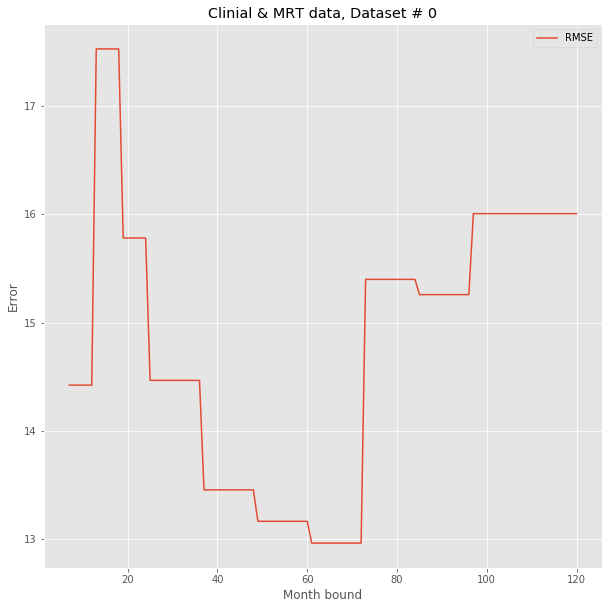

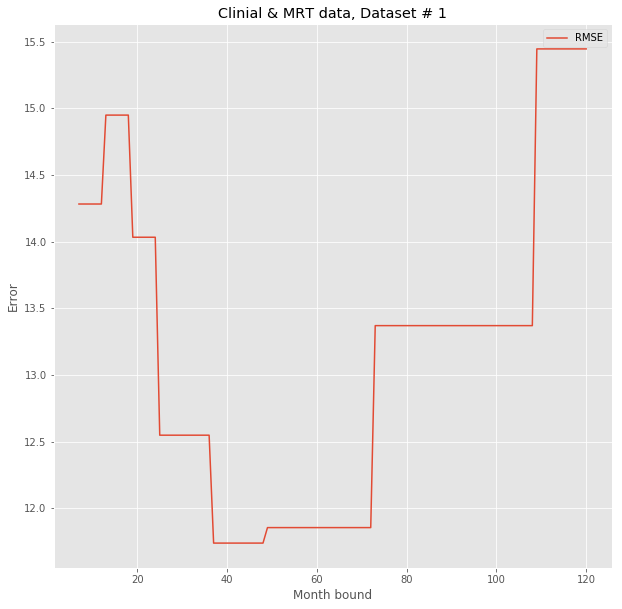

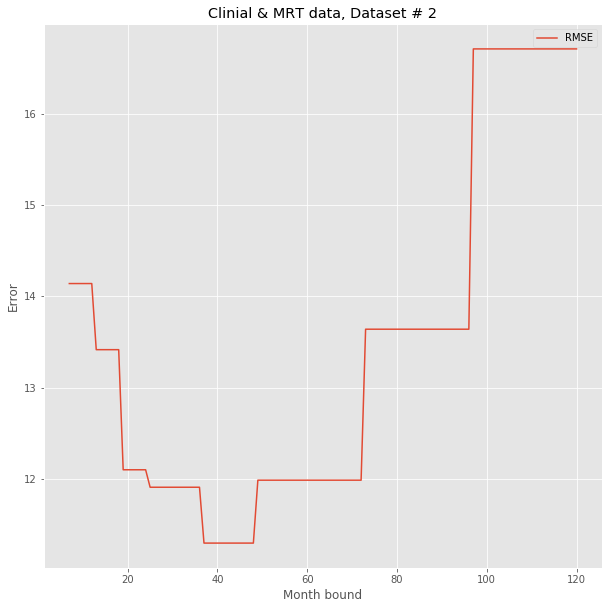

In [41]:
y_s = [None, None, None]
x_s = [None, None, None]
for dataset_num in range(Datasets_amount):
    T_test_death = act[dataset_num]
    Y = answ[dataset_num]

    test = np.array(T_test_death)

    y = []
    x = []
    for i in np.array(range(min(T_test_death)+1,max_month+1)):
        less = count_error_less_n(Y, T_test_death, i)

        y.append(sqrt(sklearn.metrics.mean_squared_error(less[0], less[1])))
        x.append(i)
    
    y_s[dataset_num] = y
    x_s[dataset_num] = x
    
    if Print_graphs:
        plt.figure(figsize(10,10))
        plt.plot(x, y, '-')
        plt.legend(['RMSE','RMSLE', 'CV', 'R2'])
        plt.ylabel('Error')
        plt.xlabel('Month bound')
        plt.title('Clinial & MRT data, Dataset # {}'.format(dataset_num))
        

In [42]:
def get_area(pred, act):
    res = df.loc[df['Предсказанный месяц дебюта'] == pred].loc[df['Фактический месяц дебюта'] == act].shape[0]
    return res

/home/l0ki5/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


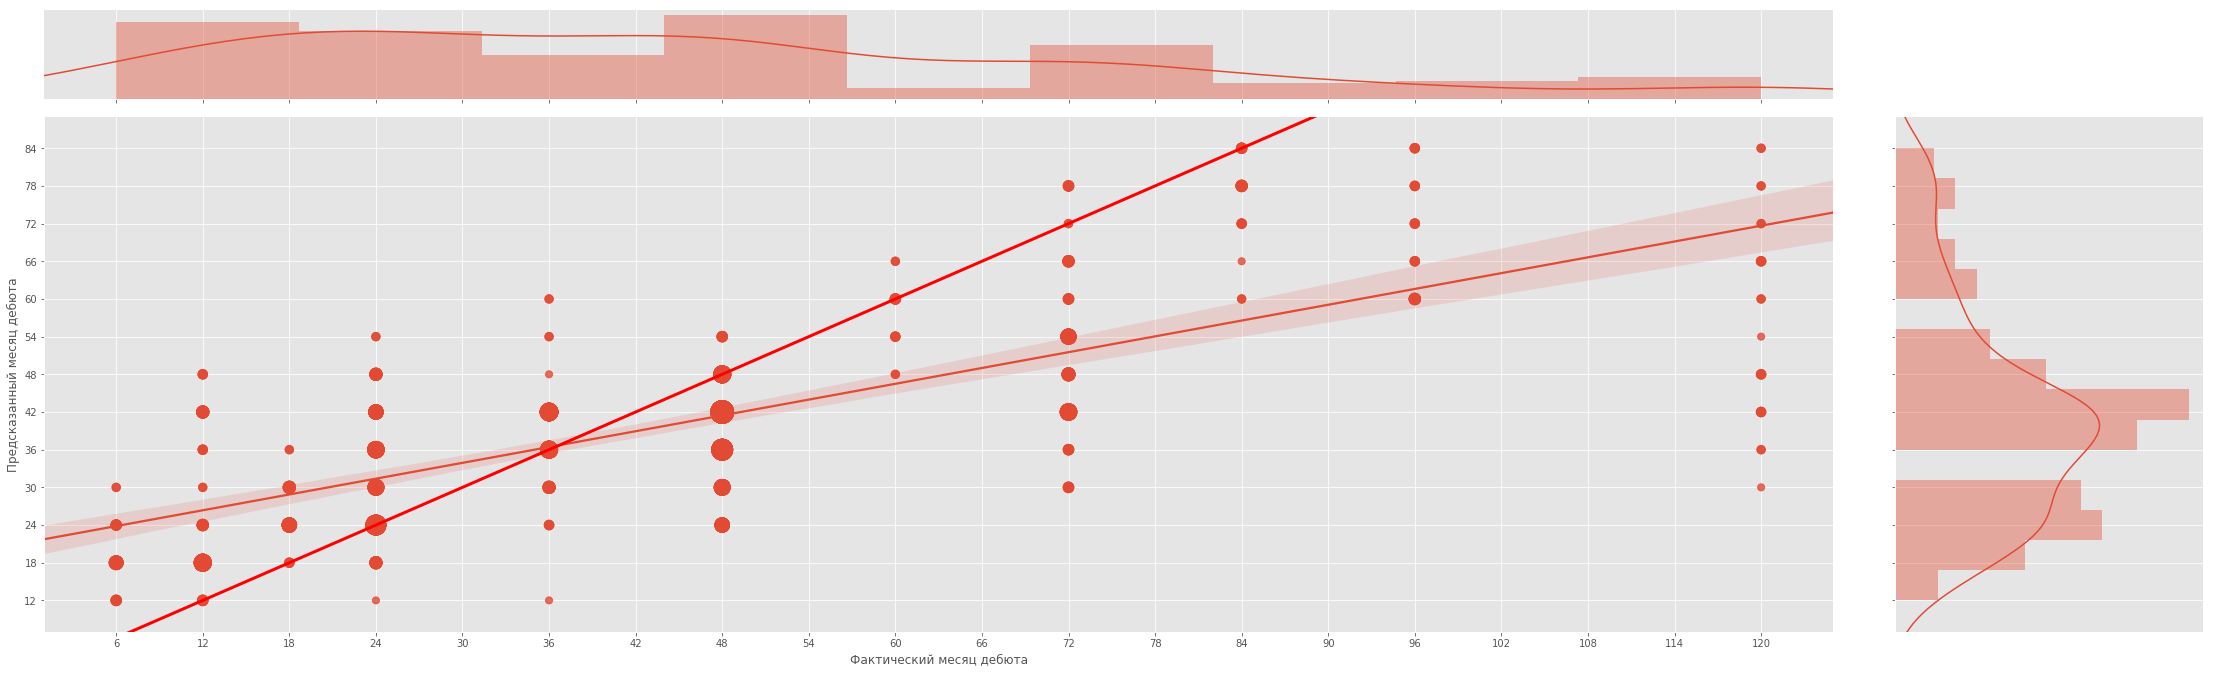

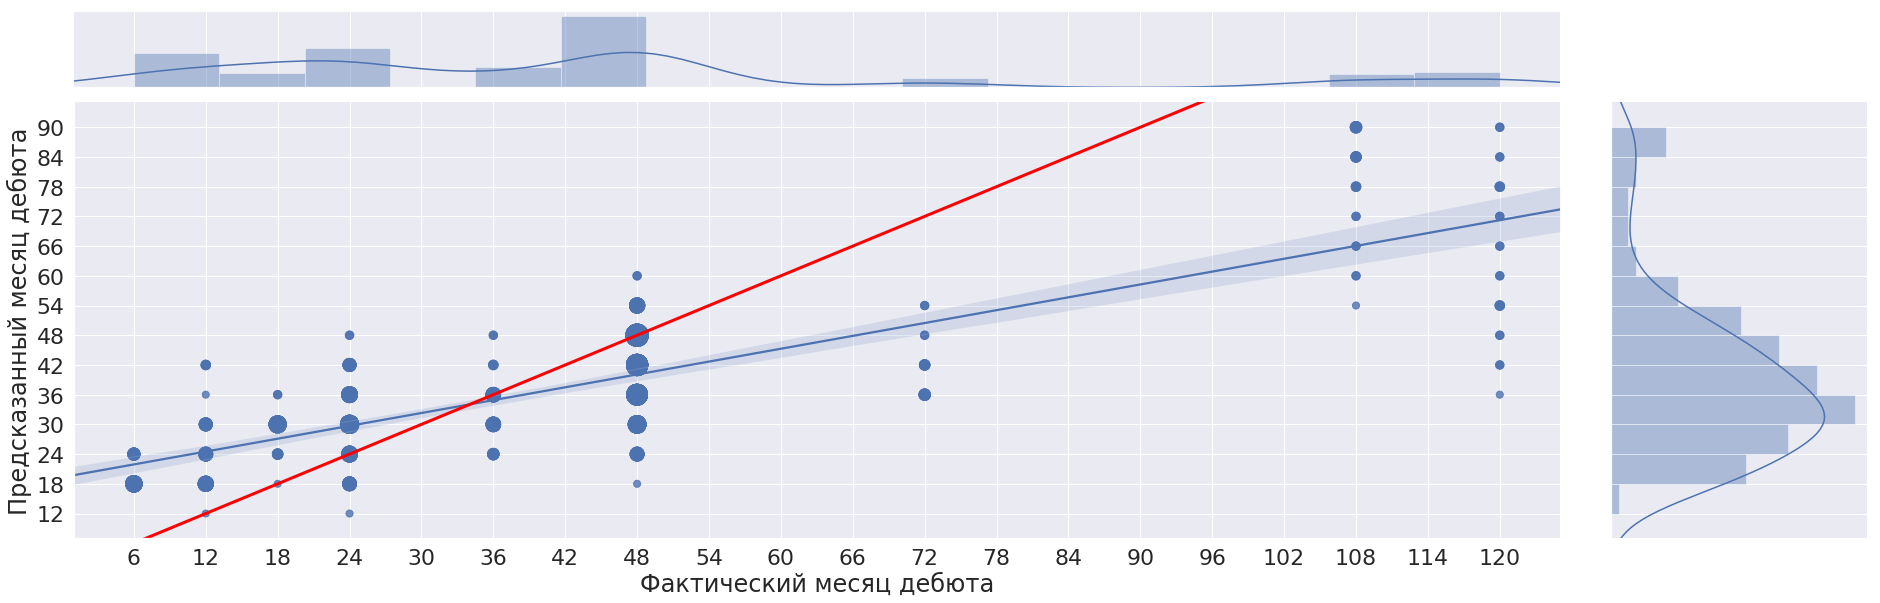

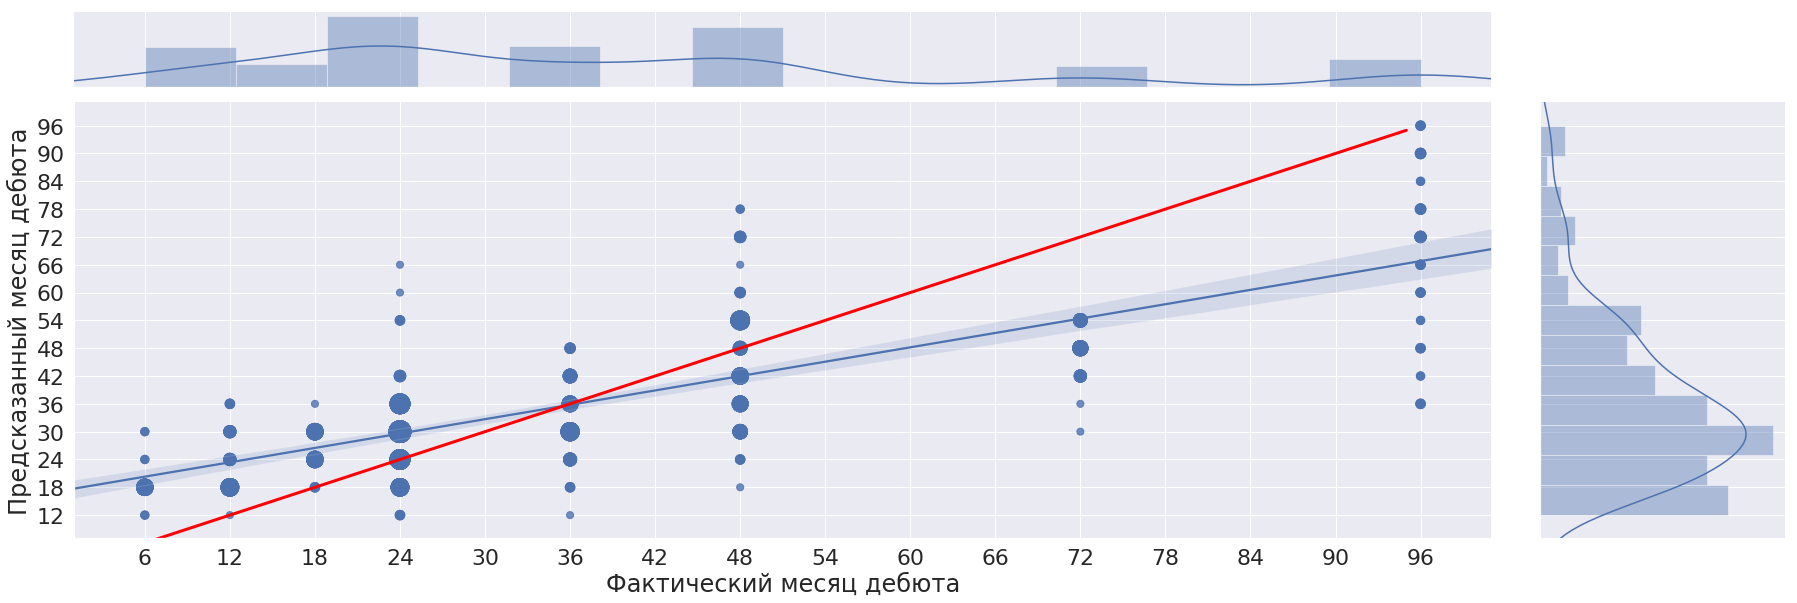

In [43]:
if Print_graphs:
    for dataset_num in range(Datasets_amount):
        T_test_death = act[dataset_num]
        Y = answ[dataset_num]
        preds = np.vstack([Y, T_test_death])

        df = pd.DataFrame(preds.T, columns = ['Предсказанный месяц дебюта', 'Фактический месяц дебюта'])
        df['new_column'] = np.vectorize(get_area)(df['Предсказанный месяц дебюта'], df['Фактический месяц дебюта'])

        g = sns.jointplot(data = df, x= 'Фактический месяц дебюта', y = 'Предсказанный месяц дебюта',\
                          xlim = (min(df['Фактический месяц дебюта'])-5,max(df['Фактический месяц дебюта']+5)),\
                          ylim = (min(df['Предсказанный месяц дебюта'])-5,max(df['Предсказанный месяц дебюта']+5)),\
                          kind = 'reg', scatter_kws={'s':30+20*df['new_column']})#, palette=sns.diverging_palette(240, 10, n=2), linewidth=5.5)
        sns.set(font_scale=2)
        sns.lineplot(x= list(range(int(min(df['Фактический месяц дебюта'])),\
                                   int(max(df['Фактический месяц дебюта'])))),\
                     y= list(range(int(min(df['Фактический месяц дебюта'])),\
                                   int(max(df['Фактический месяц дебюта'])))),\
                     linewidth = 3, color = 'red')

        g.fig.set_size_inches((35,10))
        g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(6))
        g.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(6))

        if Save_graphs:
            g.savefig('month_dist.pdf', dpi = 300)
        if Save_results:
            df.to_pickle('results\{}\{}_{}.pckl'.format(Type, Features, dataset_num))

In [44]:
results = pd.read_csv('result.csv').drop(columns = ['Unnamed: 0'])
result_sample = pd.read_csv('result_sample.csv').drop(columns = ['Unnamed: 0'])

for dataset_num in range(Datasets_amount):
    for i in range(len(result_sample.columns)):
        result_sample[result_sample.columns[i]] = res_arrs[dataset_num][i]
    results = pd.concat([results, result_sample]).reset_index(drop= True)

In [31]:
if Save_results:
    results.to_csv('result.csv')
    
    for dataset_num in range(Datasets_amount):
        if Type != 'LogisticRegression':
            g = open('results/{}/y_{}_{}_{}.txt'.format(Type, Features, Calibration_split_bound, dataset_num), 'w')
            f = open('results/{}/x_{}_{}_{}.txt'.format(Type, Features, Calibration_split_bound, dataset_num), 'w')
        else:
            g = open('results/{}/y_{}_{}.txt'.format(Type, Features, dataset_num), 'w') 
            f = open('results/{}/x_{}_{}.txt'.format(Type, Features, dataset_num), 'w') 
        for elem in y_s[dataset_num]:
            g.write('{}\n'.format(elem))
        for elem in x_s[dataset_num]:
            f.write('{}\n'.format(elem))
        g.close()
        f.close()

In [83]:
# less = []
# for i in 6*np.array(range(1,max_month//6 + 1)):
#     less = count_error_less_n(Y, T_test_death, i)
#     #new
#     string = 'sklearn RMSE при данных меньше {}:{}'.format(i,\
#                                                            sqrt(sklearn.metrics.mean_squared_error(less[0], less[1])))
#     print(string)

#     test = np.array(less[0])
#     y = np.array(less[1])

#     SE = abs(test - y).sum()/len(y)

#     string = 'максимально мы ошиблись на:{}'.format(abs(test - y).max())
#     print(string)
    
#     max_indexes = []
#     for i in range(len(abs(test-y))):
#         if abs(test-y)[i] == abs(test-y).max():
#             max_indexes.append(i)

In [84]:
# for i in range(len(answers)):
#     plt.figure(figsize(10,5))
#     plt.plot(list(range(0,121,6)), answers[i])
#     plt.xlabel('Month')
#     plt.ylabel('Probability')
#     plt.title('For patient_{} actual answer is {}, predict is {}'.format(Ndf.RID.values[i],\
#                                                                          T_test_death[i], np.argmax(answers[i])*6))
#     plt.xlim(0, 120)
#     plt.ylim(0, max(answers[i])*1.1)
#     plt.xticks(np.arange(0, 125, 6), fontsize = 14)
#     plt.yticks(np.arange(0, max(answers[i])*1.1, 0.1), fontsize = 14)
# #     plt.savefig('patient_{}.png'.format(Ndf.RID.values[i]))